In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

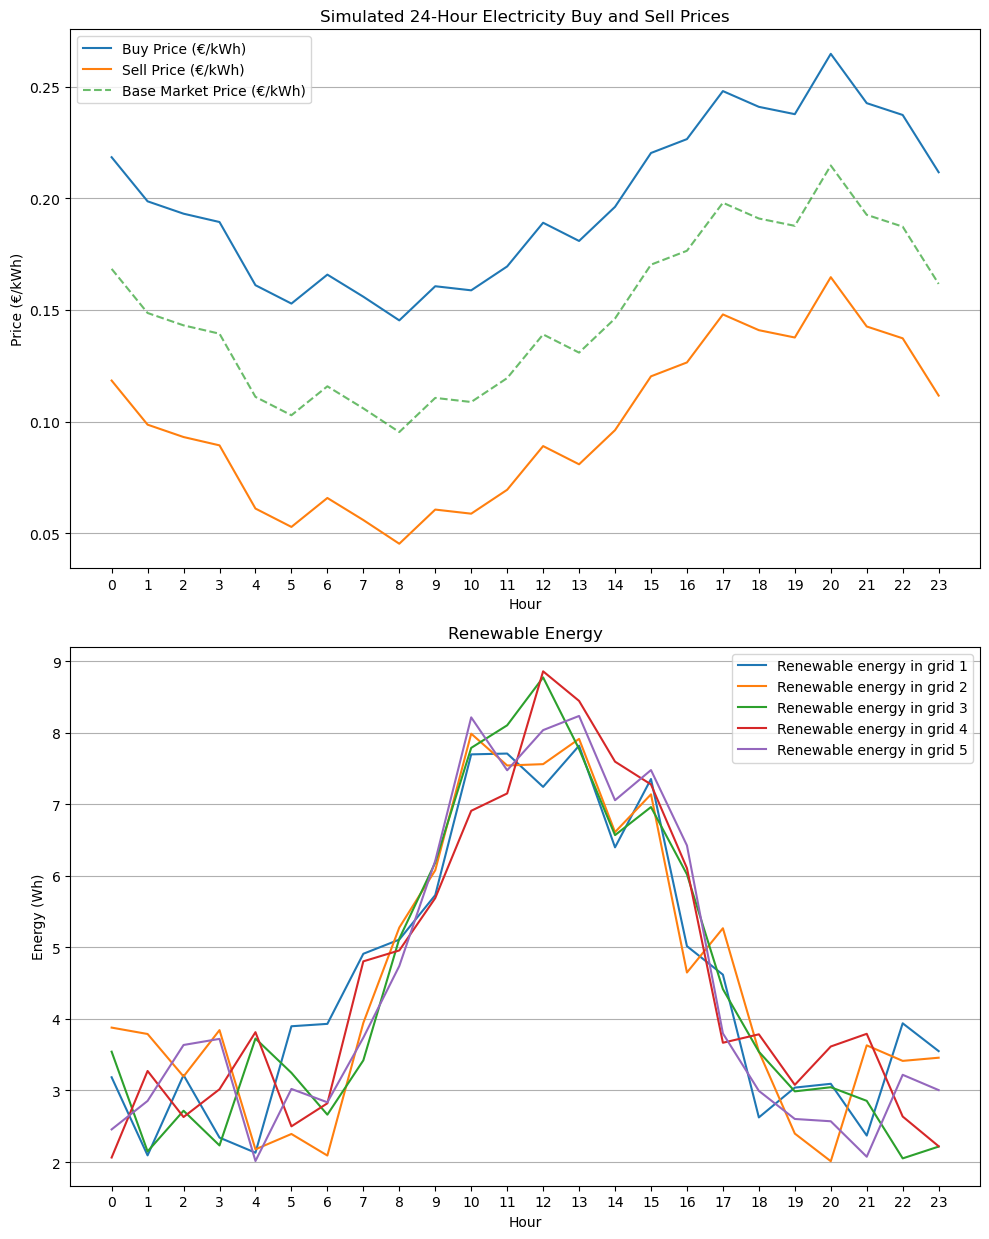

In [10]:
# Set seed for reproducibility
np.random.seed(42)

# === 1. Time Horizon ===
H = 24
horizon = 6
N = 5
M = 5

hours = np.arange(H)
base_price = 0.15
amplitude = 0.10

q = np.zeros((M,H))


# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))  # 1 row, 2 columns



noise = np.random.normal(0, 0.01, size=H)
# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)
    
# Add asymmetric buy/sell prices
margin = 0.05
c = prices + margin
p = prices - margin
p = np.clip(p, 0.01, None)  # Prevent negative prices

# First subplot: Buy and Sell Prices
axs[0].plot(hours, c, label='Buy Price (€/kWh)')
axs[0].plot(hours, p, label='Sell Price (€/kWh)')
axs[0].plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
axs[0].set_title("Simulated 24-Hour Electricity Buy and Sell Prices")
axs[0].set_xlabel("Hour")
axs[0].set_ylabel("Price (€/kWh)")
axs[0].grid(axis='y')
axs[0].set_xticks(range(0, 24))
axs[0].legend()

for m in range(M):    
    # === 3. Generate Renewable Energy ===
    pv_gen = np.maximum(0, 5 * np.sin((hours - 6) * np.pi / 12))  # PV peaks at noon
    wt_gen = 2 + np.random.rand(H) * 2  # Wind is random but consistent
    q[m] = (pv_gen + wt_gen)
    # Second subplot: Renewable energy
    axs[1].plot(np.arange(H), q[m], label = f"Renewable energy in grid {m+1}")
    axs[1].set_title("Renewable Energy")
    axs[1].set_xlabel("Hour")
    axs[1].set_ylabel("Energy (Wh)")
    axs[1].grid(axis='y')
    axs[1].set_xticks(range(0, 24))
axs[1].legend()
plt.tight_layout()
plt.savefig("Multilayered environmental parameters", dpi=300)
plt.show()

In [12]:
# Parameters
c1 = 5
c2 = 1
np.random.seed(42)
L_target = np.random.uniform(70, 90, size=(M,N))
L_init = np.random.uniform(20, 60, size=(M,N))

d_min = np.zeros((M, H))
d_max = np.ones((M, H)) * 10

f_min = np.zeros((M, H))
f_max = np.ones((M, H)) * 10

# Decision variables for each agent
x = [cp.Variable(2*H) for _ in range(M)]

constraints = []
objective = 0
cost_terms = []
target_terms = []

for m in range(M):
    d = x[m][:H]
    f = x[m][H:2*H]

    constraints += [
        d >= d_min[m],
        d <= d_max[m],
        f >= f_min[m],
        f <= f_max[m]
    ]

    for h in range(1, H):
        constraints += [
            cp.abs(f[h-1] - f[h]) <= 1,
            cp.abs(d[h-1] - d[h]) <= 1
        ]

    energy_cost = cp.sum(cp.multiply(c, d) / q[m] - cp.multiply(p, f) / q[m])
    expected_load = cp.sum(L_target[m] - L_init[m])
    remaining_energy = cp.sum(q[m] + d - f)
    energy_target =  cp.sum_squares(expected_load - remaining_energy)
    objective += c1 * energy_cost + c2 *energy_target
    cost_terms.append(energy_cost)
    target_terms.append(energy_target)

# Solve the problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(solver="CLARABEL")


# Collect data for plotting
d_history = np.array([x[m][:H].value for m in range(M)])
f_history = np.array([x[m][H:2*H].value for m in range(M)])

for m in range(M):
    print(f"Objective functions in Agent {m}: "
          f"Cost term: {cost_terms[m].value:.2f}, "
          f"Target term: {target_terms[m].value:.2f}, "
          f"overall objective: {cost_terms[m].value + target_terms[m].value:.2f}")

Objective functions in Agent 0: Cost term: 4.19, Target term: 0.02, overall objective: 4.21
Objective functions in Agent 1: Cost term: 2.63, Target term: 0.01, overall objective: 2.65
Objective functions in Agent 2: Cost term: 3.16, Target term: 0.02, overall objective: 3.17
Objective functions in Agent 3: Cost term: 3.56, Target term: 0.01, overall objective: 3.58
Objective functions in Agent 4: Cost term: 3.08, Target term: 0.02, overall objective: 3.09


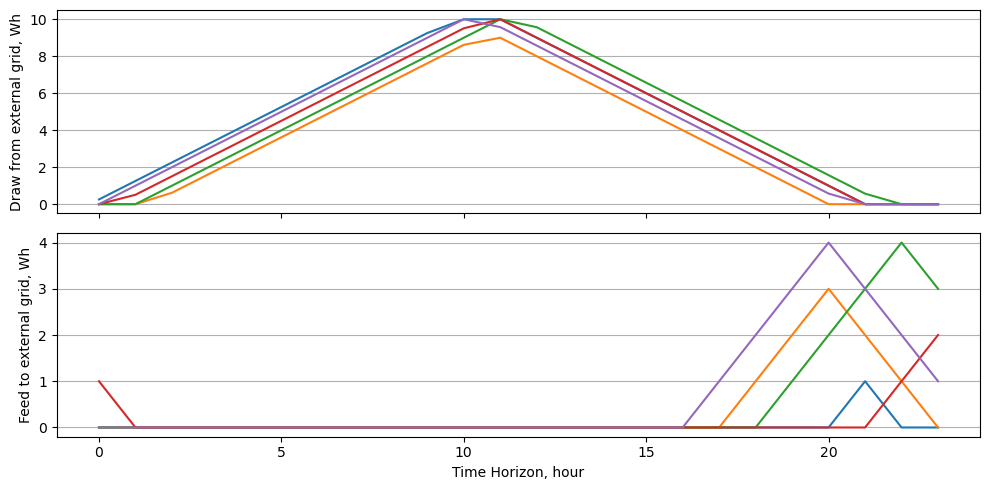

In [13]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 2*2.5), sharex=True)

for m in range(M):
    axes[0].plot(d_history[m])
    axes[0].grid(axis='y')
    axes[0].set_ylabel("Draw from external grid, Wh")

for m in range(M):
    axes[1].plot(f_history[m])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Feed to external grid, Wh")
    
    

axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("Centralised high-layer framework", dpi=300)
plt.show()

In [15]:
# Parameters
L_min = np.ones((M, N, H)) * 20
L_max = np.ones((M, N, H)) * 100

l_min = np.zeros((M, N, H))
l_max = np.ones((M, N, H)) * 10

r_min = np.zeros((M, N, H))
r_max = np.ones((M, N, H)) * 10

# Decision variables for each agent
x = [[cp.Variable(3*H) for _ in range(N)] for _ in range(M)]

constraints = []
objective = 0
energy_terms = []
penalty_terms = []

for m in range(M):
    for n in range(N):
        l = x[m][n][:H]
        r = x[m][n][H:2*H]
        L = x[m][n][2*H:3*H]
        
        constraints += [
            L >= L_min[m][n],
            L <= L_max[m][n],
            l >= l_min[m][n],
            l <= l_max[m][n],
            r >= r_min[m][n],
            r <= r_max[m][n]
        ]
    
        constraints += [
            L[0] == L_init[m][n] + l[0] - r[0]
        ]
        
        for h in range(1, H):
            constraints += [
                L[h] == L[h-1] + l[h] - r[h],
                cp.abs(l[h-1] - l[h]) <= 1,
                cp.abs(r[h-1] - r[h]) <= 1
            ]
        
        penalty_term = (L[-1]-L_target[m,n])**2
        objective += penalty_term
        penalty_terms.append(penalty_term)

    #overall energy consumption

    constraints +=[q[m] + d_history[m] - f_history[m]== cp.sum(x[m], axis=0)[:H] - cp.sum(x[m], axis=0)[H:2*H]]

# Solve the problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(solver="CLARABEL")

# Collect data for plotting
l_history = np.array([[x[m][n][:H].value for n in range(N)] for m in range(M)])
r_history = np.array([[x[m][n][H:2*H].value for n in range(N)] for m in range(M)])
L_history = np.array([[x[m][n][2*H:].value for n in range(N)] for m in range(M)])

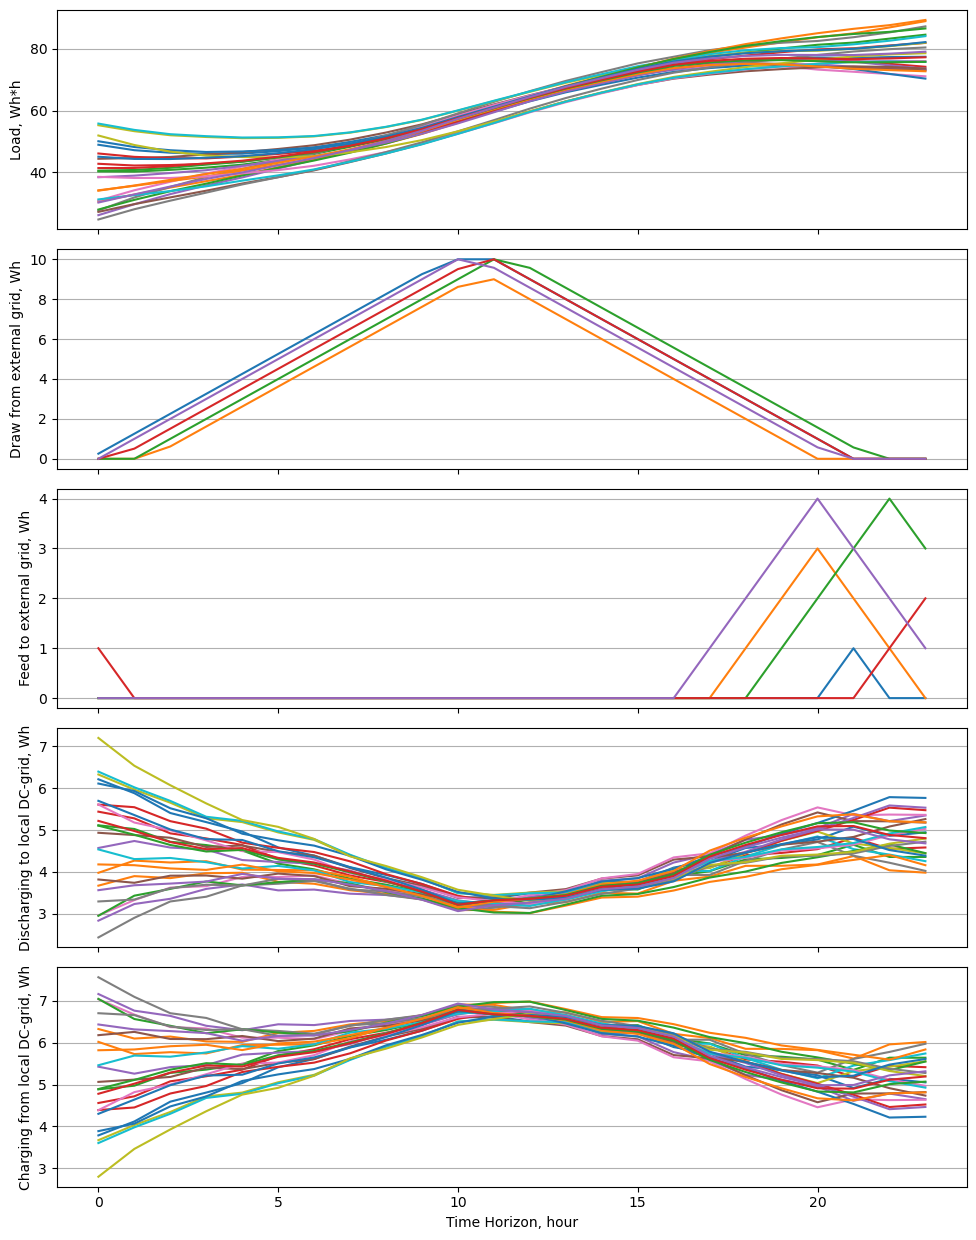

In [19]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(10, 5*2.5), sharex=True)
for m in range(M):
    for n in range(N):
        #axes[0].plot(np.full(H,L_target[n]))
        axes[0].plot(L_history[m][n], label =f'agent {n}')
        axes[0].grid(axis='y')
        #axes[0].legend()
        axes[0].set_ylabel("Load, Wh*h")
    

    axes[1].plot(d_history[m])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Draw from external grid, Wh")
    

    axes[2].plot(f_history[m])
    axes[2].grid(axis='y')
    axes[2].set_ylabel("Feed to external grid, Wh")
        
    for n in range(N):
        axes[3].plot(r_history[m][n])
        axes[3].grid(axis='y')
        axes[3].set_ylabel("Discharging to local DC-grid, Wh")
        
    for n in range(N):
        axes[4].plot(l_history[m][n])
        axes[4].grid(axis='y')
        axes[4].set_ylabel("Charging from local DC-grid, Wh")
    

axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("Centralised multilayer framework", dpi=300)
plt.show()

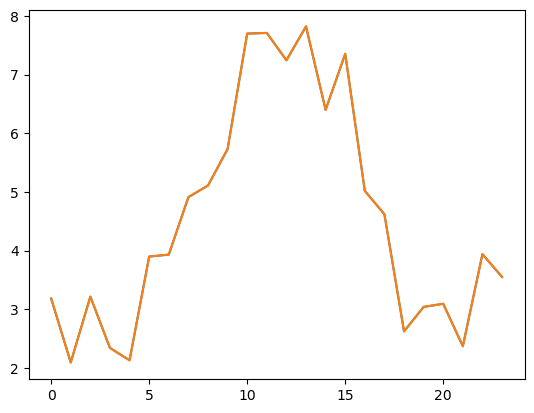

In [58]:
for m in range(M):
    plt.plot(-d_history[m]+f_history[m]+np.sum(l_history[m],axis=0)-np.sum(r_history[m],axis=0))
    plt.plot(q[m])

In [60]:
total_cost = 0
for m in range(M):
    cost = np.sum(c * d_history[m] / q[m] - p * f_history[m] / q[m]) + (L_target[m] - L_history[m][:,-1]).T@(L_target[m] - L_history[m][:,-1])
    print(cost)
    total_cost +=cost
print("Average:", total_cost/M)


3.669883634303336
Average: 3.669883634303336


In [62]:
for m in range(M):
    for n in range(N):
        print(f"Error between target and real load of {1+n} agent is {100 * (L_target[m][n] - L_history[m][n][-1])/L_target[m][n]:.2f}%")

Error between target and real load of 1 agent is 0.03%
Error between target and real load of 2 agent is 0.03%
Error between target and real load of 3 agent is 0.03%
Error between target and real load of 4 agent is 0.03%
Error between target and real load of 5 agent is 0.03%


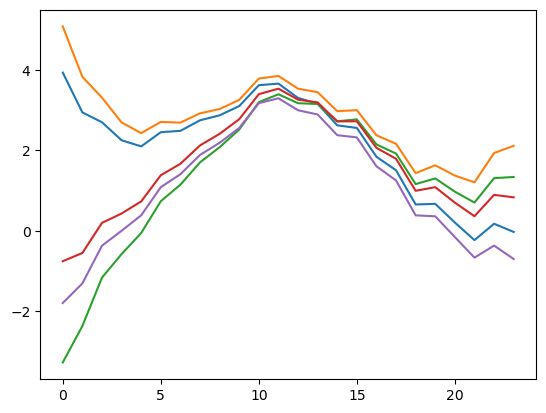

In [70]:
for n in range(N):
    plt.plot(l_history[0][n] - r_history[0][n])